# **Week 13 Recitation Solutions**

Today we will be working on the techniques in chapter 23 and 24. Using a dataset of your choice (if you don’t want to choose I recommend either the housing data or the premier league data):

Note, if you want to compare the steps to these questions with the examples in the textbook, check out section 24.2. Also the introduction in 24.1 gives a very nice high level overview.

For this document I am going to use the premier league game-week level data. Since these are pretty straight forward I will do two examples (one with categorical data and one with continuous data). 

I will need the ```tidyverse``` and ```modelr``` packages so I import those, and then I import the data.

In [1]:
library(tidyverse)
library(modelr)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1       ✔ purrr   0.3.2  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [32]:
df <- read_csv("<filepath>/Fantasy Premier League Data Game Level.csv")

Parsed with column specification:
cols(
  .default = col_double(),
  name = col_character(),
  kickoff_time_formatted = col_character(),
  kickoff_time = col_datetime(format = ""),
  was_home = col_logical()
)
See spec(...) for full column specifications.


## **Categorical Example: Effect of assists on total points - removing effects of goals scored**

### 1) Investigate the bivariate distributions (scatter plots) between variables until you find a relationship you think worth investigating.

First I will investigate the relationship between ```assists``` and ```total_points```. My hypothesis is that the more asists a player earns in a game the more points that player will have earned in that game. These is a pretty straightforward assumption, and I actually know, _a priori_, that it is true since total points in this fantasy league are calculated on a number of metrics one of which is assists. According to [the rule book](https://fantasy.premierleague.com/help/rules) each assist is worth 3 points. So let's confirm this hypothesis is true in our data.

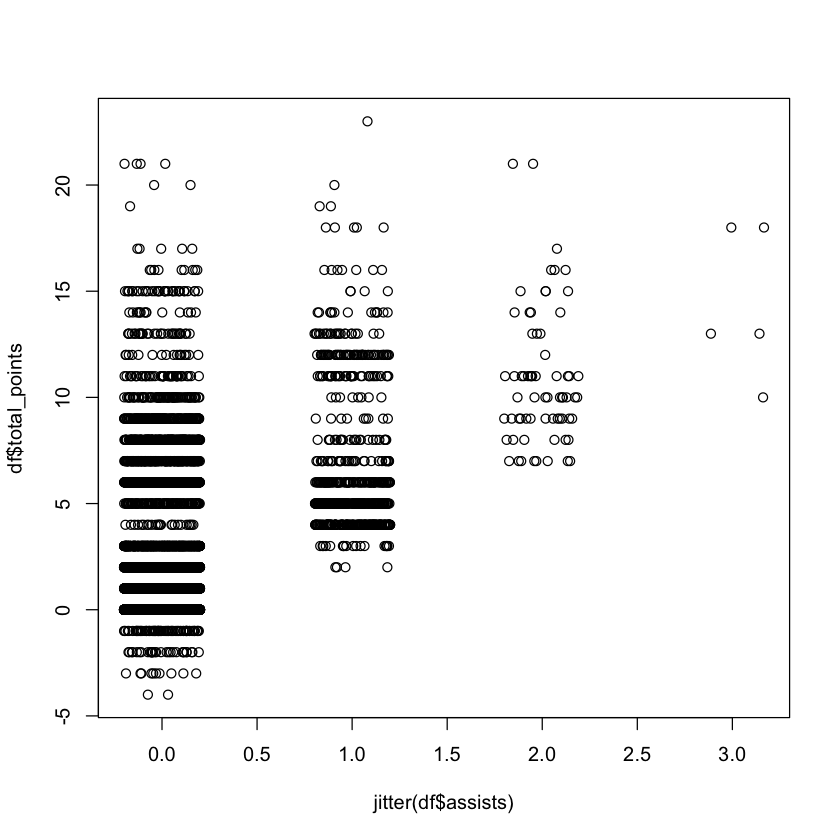

In [72]:
plot(jitter(df$assists,df$total_points)

It looks like we are going to be correct - as we can clearly see in the plot above, there appears to be a positive relationship between assists and points. However, the trend appears to peter out slightly for high levels of assists. This is interesting because I don't see any reason that the second assist should be worth less than the first assist in terms of points. Maybe there is a confounding variable that is also affecting total points. If we can remove the effect of the confounding variable on total points then we will be able to see the relationship between assists and points more clearly.

### 2) Run a basic linear model and interpret it. Is there another variable causing bias? If so, calculate your residuals and re-run the model on the residuals, is the model better?

Lets make the relationship we currently see between assists and points more formal. We can run a linear regression to quantify exactly the relationship.

In [75]:
m1_pre <- lm(total_points ~ assists, data = df)
summary(m1_pre)


Call:
lm(formula = total_points ~ assists, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-7.0032 -1.1985 -1.1985  0.8015 19.8015 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.19852    0.01577   75.98   <2e-16 ***
assists      5.26823    0.07023   75.01   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.286 on 21788 degrees of freedom
Multiple R-squared:  0.2052,	Adjusted R-squared:  0.2052 
F-statistic:  5626 on 1 and 21788 DF,  p-value: < 2.2e-16


Great, there does appear to be a positive relationship of around 5 points per assist. Something jumps out as odd here, we know each assist is worth 3 points but our model predicts they are worth 5. Our model could be over-estimating the value of assists because players who get a lot of assists also tend to get a lot of goals, or passes or some other metric that also contributes to points.

We should also note the R-squared is low so assists only account for a small portion of the points. Lets see if we can remove some of the effects on points of other variables to make this relationship more explicit.

The main component of point calculations is how many goals the player scored in that game so lets see if ```goals_scored``` is the confounding variable we are looking for.

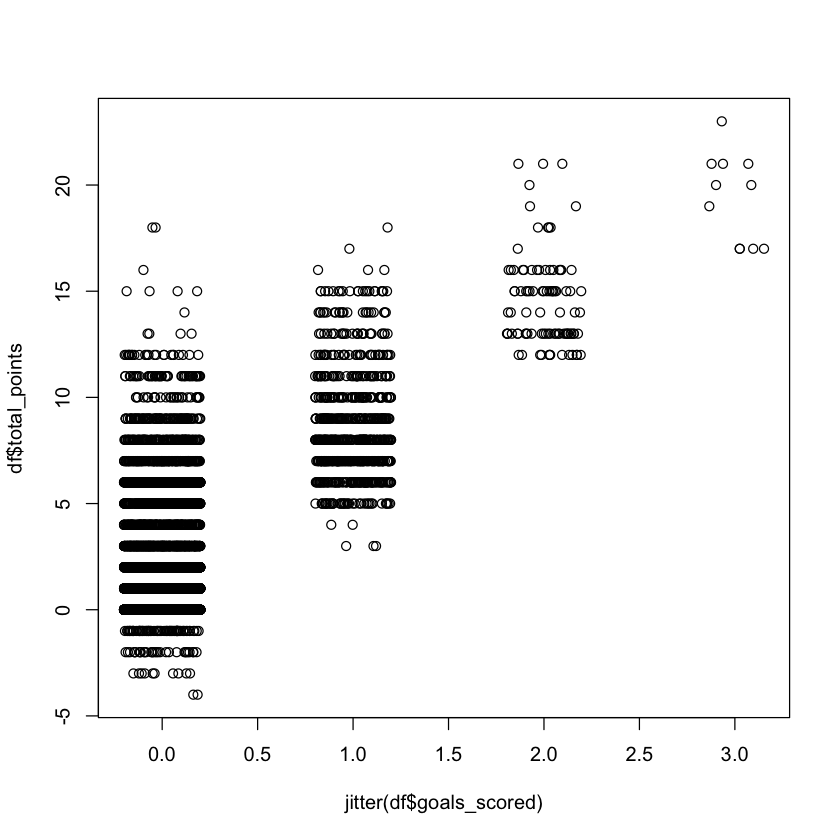

In [76]:
plot(jitter(df$goals_scored),df$total_points)

Nice, this also seems to have a strong positive relationship to points. So lets calculate the residuals and see if the relationship between assists and points (after removing the effects of goals scored) is more clear.

In [77]:
m1 <- lm(total_points ~ goals_scored, data=df)
df1 <- df %>% add_residuals(m1,"resid_points")

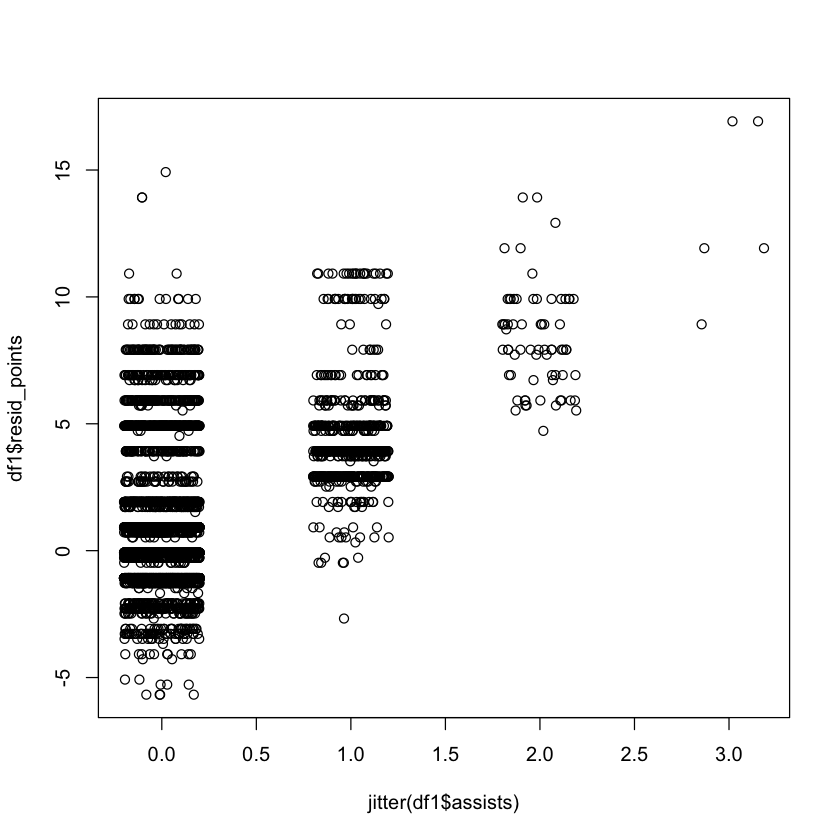

In [78]:
plot(jitter(df1$assists), df1$resid_points)

Awesome, look at that, the slight loss of the trend we saw at the beginning is gone and the linear trend between assists and points we expected to see is clearer. Now lets see if this trend holds up formally. To do this we can run a linear regression of assists on the residual points we calculated above (points with the effect of goals scored removed) and compare that to the first model we ran in step 1.

In [79]:
m1_post <- lm(resid_points ~ assists, data=df1)
summary(m1_pre)
summary(m1_post)


Call:
lm(formula = total_points ~ assists, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-7.0032 -1.1985 -1.1985  0.8015 19.8015 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.19852    0.01577   75.98   <2e-16 ***
assists      5.26823    0.07023   75.01   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.286 on 21788 degrees of freedom
Multiple R-squared:  0.2052,	Adjusted R-squared:  0.2052 
F-statistic:  5626 on 1 and 21788 DF,  p-value: < 2.2e-16



Call:
lm(formula = resid_points ~ assists, data = df1)

Residuals:
    Min      1Q  Median      3Q     Max 
-6.9203 -0.8913 -0.8913  0.1087 15.1087 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.18991    0.01126  -16.87   <2e-16 ***
assists      4.43527    0.05014   88.46   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.632 on 21788 degrees of freedom
Multiple R-squared:  0.2642,	Adjusted R-squared:  0.2642 
F-statistic:  7825 on 1 and 21788 DF,  p-value: < 2.2e-16


Great, this is starting to look better. We now see that our model predicts assists are worth 4 points. This is moving in the right direction from 5 points, though there is likely still another confounding variable since we know assists to be worth 3 points.

Also, our R-squared has increased to 0.26 which is confirmation that we have indeed removed one confounding variable and now assists are responsible for a larger share of the points a player earns.

We could repeat this process with ```attempted_passes``` or ```clean_sheets``` next and so on.

## **Continuous Example: Effect of threat on total points - removing effects of influence**

Here I will write out the process so you can see it for a continuous variable, but not include any write up in the interest of saving time and space. The interpretation is along the same lines (though it goes in the opposite direction this time).

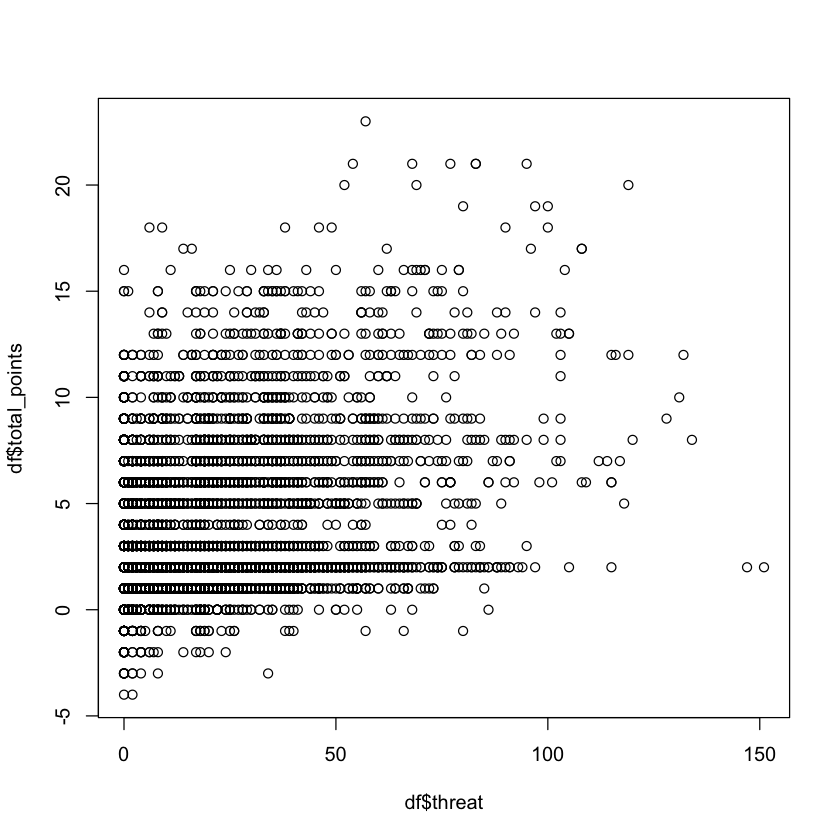

In [48]:
plot(df$threat,df$total_points)

In [88]:
m2_pre <- lm(total_points ~ threat, data = df)
summary(m2_pre)


Call:
lm(formula = total_points ~ threat, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-13.9596  -0.8467  -0.8467   0.1533  16.5528 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.846656   0.015766   53.70   <2e-16 ***
threat      0.100086   0.001045   95.81   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.15 on 21788 degrees of freedom
Multiple R-squared:  0.2964,	Adjusted R-squared:  0.2964 
F-statistic:  9180 on 1 and 21788 DF,  p-value: < 2.2e-16


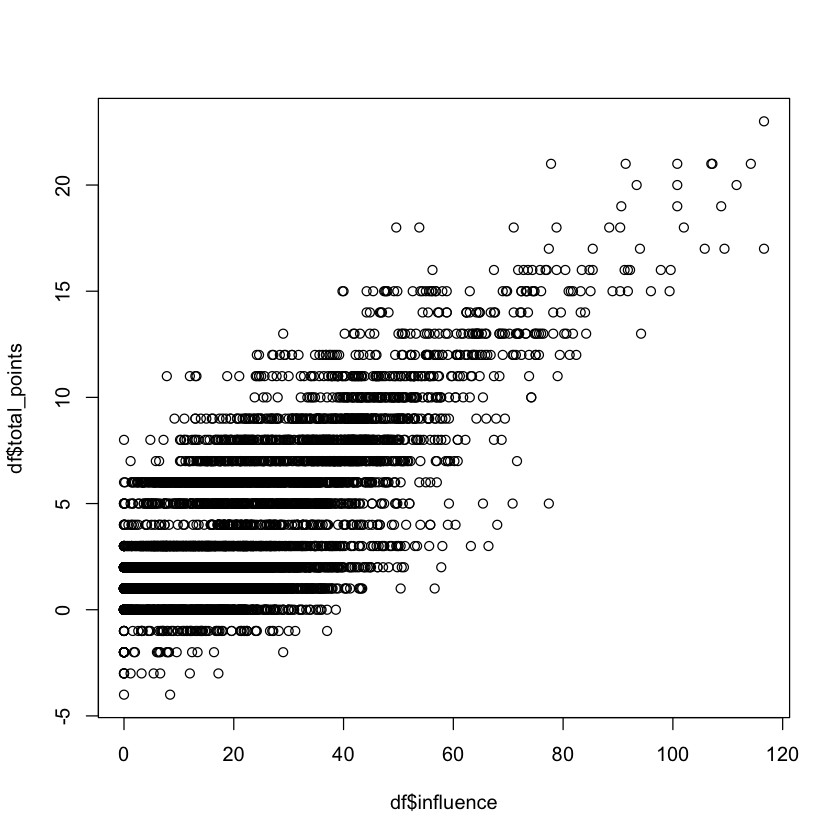

In [89]:
plot(df$influence,df$total_points)

In [90]:
m2 <- lm(total_points ~ influence, data=df)
df2 <- df %>% add_residuals(m2, "resid_points")

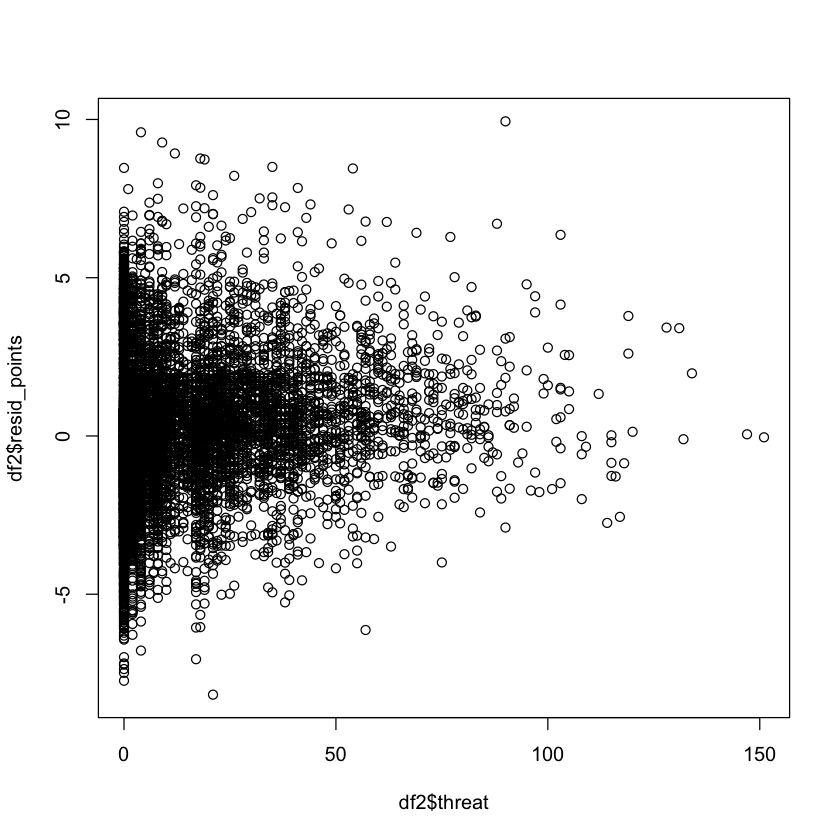

In [91]:
plot(df2$threat,df2$resid_points)

In this example, it looks like we have the opposite result - accounting for the effect of influence on total points soaked up all of the effect threat had on total points.

In [92]:
m2_post <- lm(resid_points ~ threat, data = df2)
summary(m2_pre)


Call:
lm(formula = total_points ~ threat, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-13.9596  -0.8467  -0.8467   0.1533  16.5528 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.846656   0.015766   53.70   <2e-16 ***
threat      0.100086   0.001045   95.81   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.15 on 21788 degrees of freedom
Multiple R-squared:  0.2964,	Adjusted R-squared:  0.2964 
F-statistic:  9180 on 1 and 21788 DF,  p-value: < 2.2e-16



Call:
lm(formula = resid_points ~ threat, data = df2)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.4555 -0.0571 -0.0571  0.0567  9.6272 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.1067922  0.0102690   -10.4   <2e-16 ***
threat       0.0185100  0.0006804    27.2   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.401 on 21788 degrees of freedom
Multiple R-squared:  0.03285,	Adjusted R-squared:  0.03281 
F-statistic: 740.1 on 1 and 21788 DF,  p-value: < 2.2e-16


Sure enough the R-squared value dropped to 0.032 so threat accounts for almost no points after removing the effect of influence.